C-to-Python
===

The traditonal way to extend Python with C code is to use the [ctypes](https://docs.python.org/3/library/ctypes.html) package which provides tools to build an interface between the two languages and to directly call functions in a shared library.

The code below uses:
* [ctypes](https://docs.python.org/3/library/ctypes.html)
* [numpy](https://numpy.org/)
* [Pillow](https://pypi.org/project/Pillow/)

This directory contains a Python module mypylib.py and identical code in C/C++ in mylib.cpp(h).  Look over the code before you begin.  And type *make* to build the C/C++ libraries for this example.  Two versions of the shared library are built, one with C-style linkage mylib.soc and one with C++ style linkage mylib.so.

In [1]:
import mypylib
import numpy as np

Estimating pi using uniform random numbers
-----

We'll first measure the time of Python code with our findPi function.  We use 100M random numbers thrown in a unit square to estimate the value of pi.

In [2]:
%time PI=mypylib.findPi(100*1000*1000)
print("Estimate for pi:",PI)

CPU times: user 18 s, sys: 1.11 ms, total: 18 s
Wall time: 18.5 s
Estimate for pi: 3.14160376


Next we'll use the same code written in C and called from our shared library.

First look at the interfae to our findPi function in C <br>
double findPi(long nthrows);<br>
This takes a long int as input and returns a double value.  To use this function we must define this interface using ctypes data objects.

In [5]:
from ctypes import cdll  # pythonic interfaces for C(++) libraries
from ctypes import c_double
from ctypes import c_long

# load our library and define the input/output interfaces
myclib=cdll.LoadLibrary('./mylib.soc')
myclib.findPi.argtypes = [c_long]
myclib.findPi.restype=c_double

That's it.  Now we can use our C version of findPi directly from Python

In [6]:
%time PI=myclib.findPi(100*1000*1000)
print("Estimate for pi:",PI)

CPU times: user 1.21 s, sys: 979 μs, total: 1.21 s
Wall time: 1.24 s
Estimate for pi: 3.14137108


Example 2: Visualizing the Mandelbrot Set
---

We'll begin with a pure python example to draw the [Mandelbrot set](https://en.wikipedia.org/wiki/Mandelbrot_set).

The Python interface is:

def mandel(img, re1, re2, im1, im2, nr, ni, NTRIALS=255)<br>
* img = image array[npX][npY]
* re1, re2 = range to explore on real axis
* im1, im2 = range to explore in imaginary axis
* nr, ni = number of divisions in re/im ranges
* NTRIALS = numebr of iterrations to easimate if a point is included in the set

In [7]:
import numpy as np
# define parameters for the calulation
npX=2000   # 2000 x 2000 pixel image
npY=2000
nTrials=255
re1=-2.1
re2=0.6
im1=-1.5
im2=1.5
img=np.ndarray(shape=(npX,npY), dtype=np.double) # array to hold our image

In [8]:
%time mypylib.mandel(img,re1,re2,im1,im2,npX,npY,nTrials) # this will take a moment....

CPU times: user 1min 6s, sys: 10.9 ms, total: 1min 6s
Wall time: 1min 8s


Next, let's make a nice picture.  I'll leave it as an optional exercise if you want to add color.

/tmp/ipykernel_633953/1857907330.py:4: RuntimeWarning: divide by zero encountered in log
  img=np.log(img)
/tmp/ipykernel_633953/1857907330.py:5: RuntimeWarning: invalid value encountered in cast
  img = (img/img.max()*255).astype('uint8')


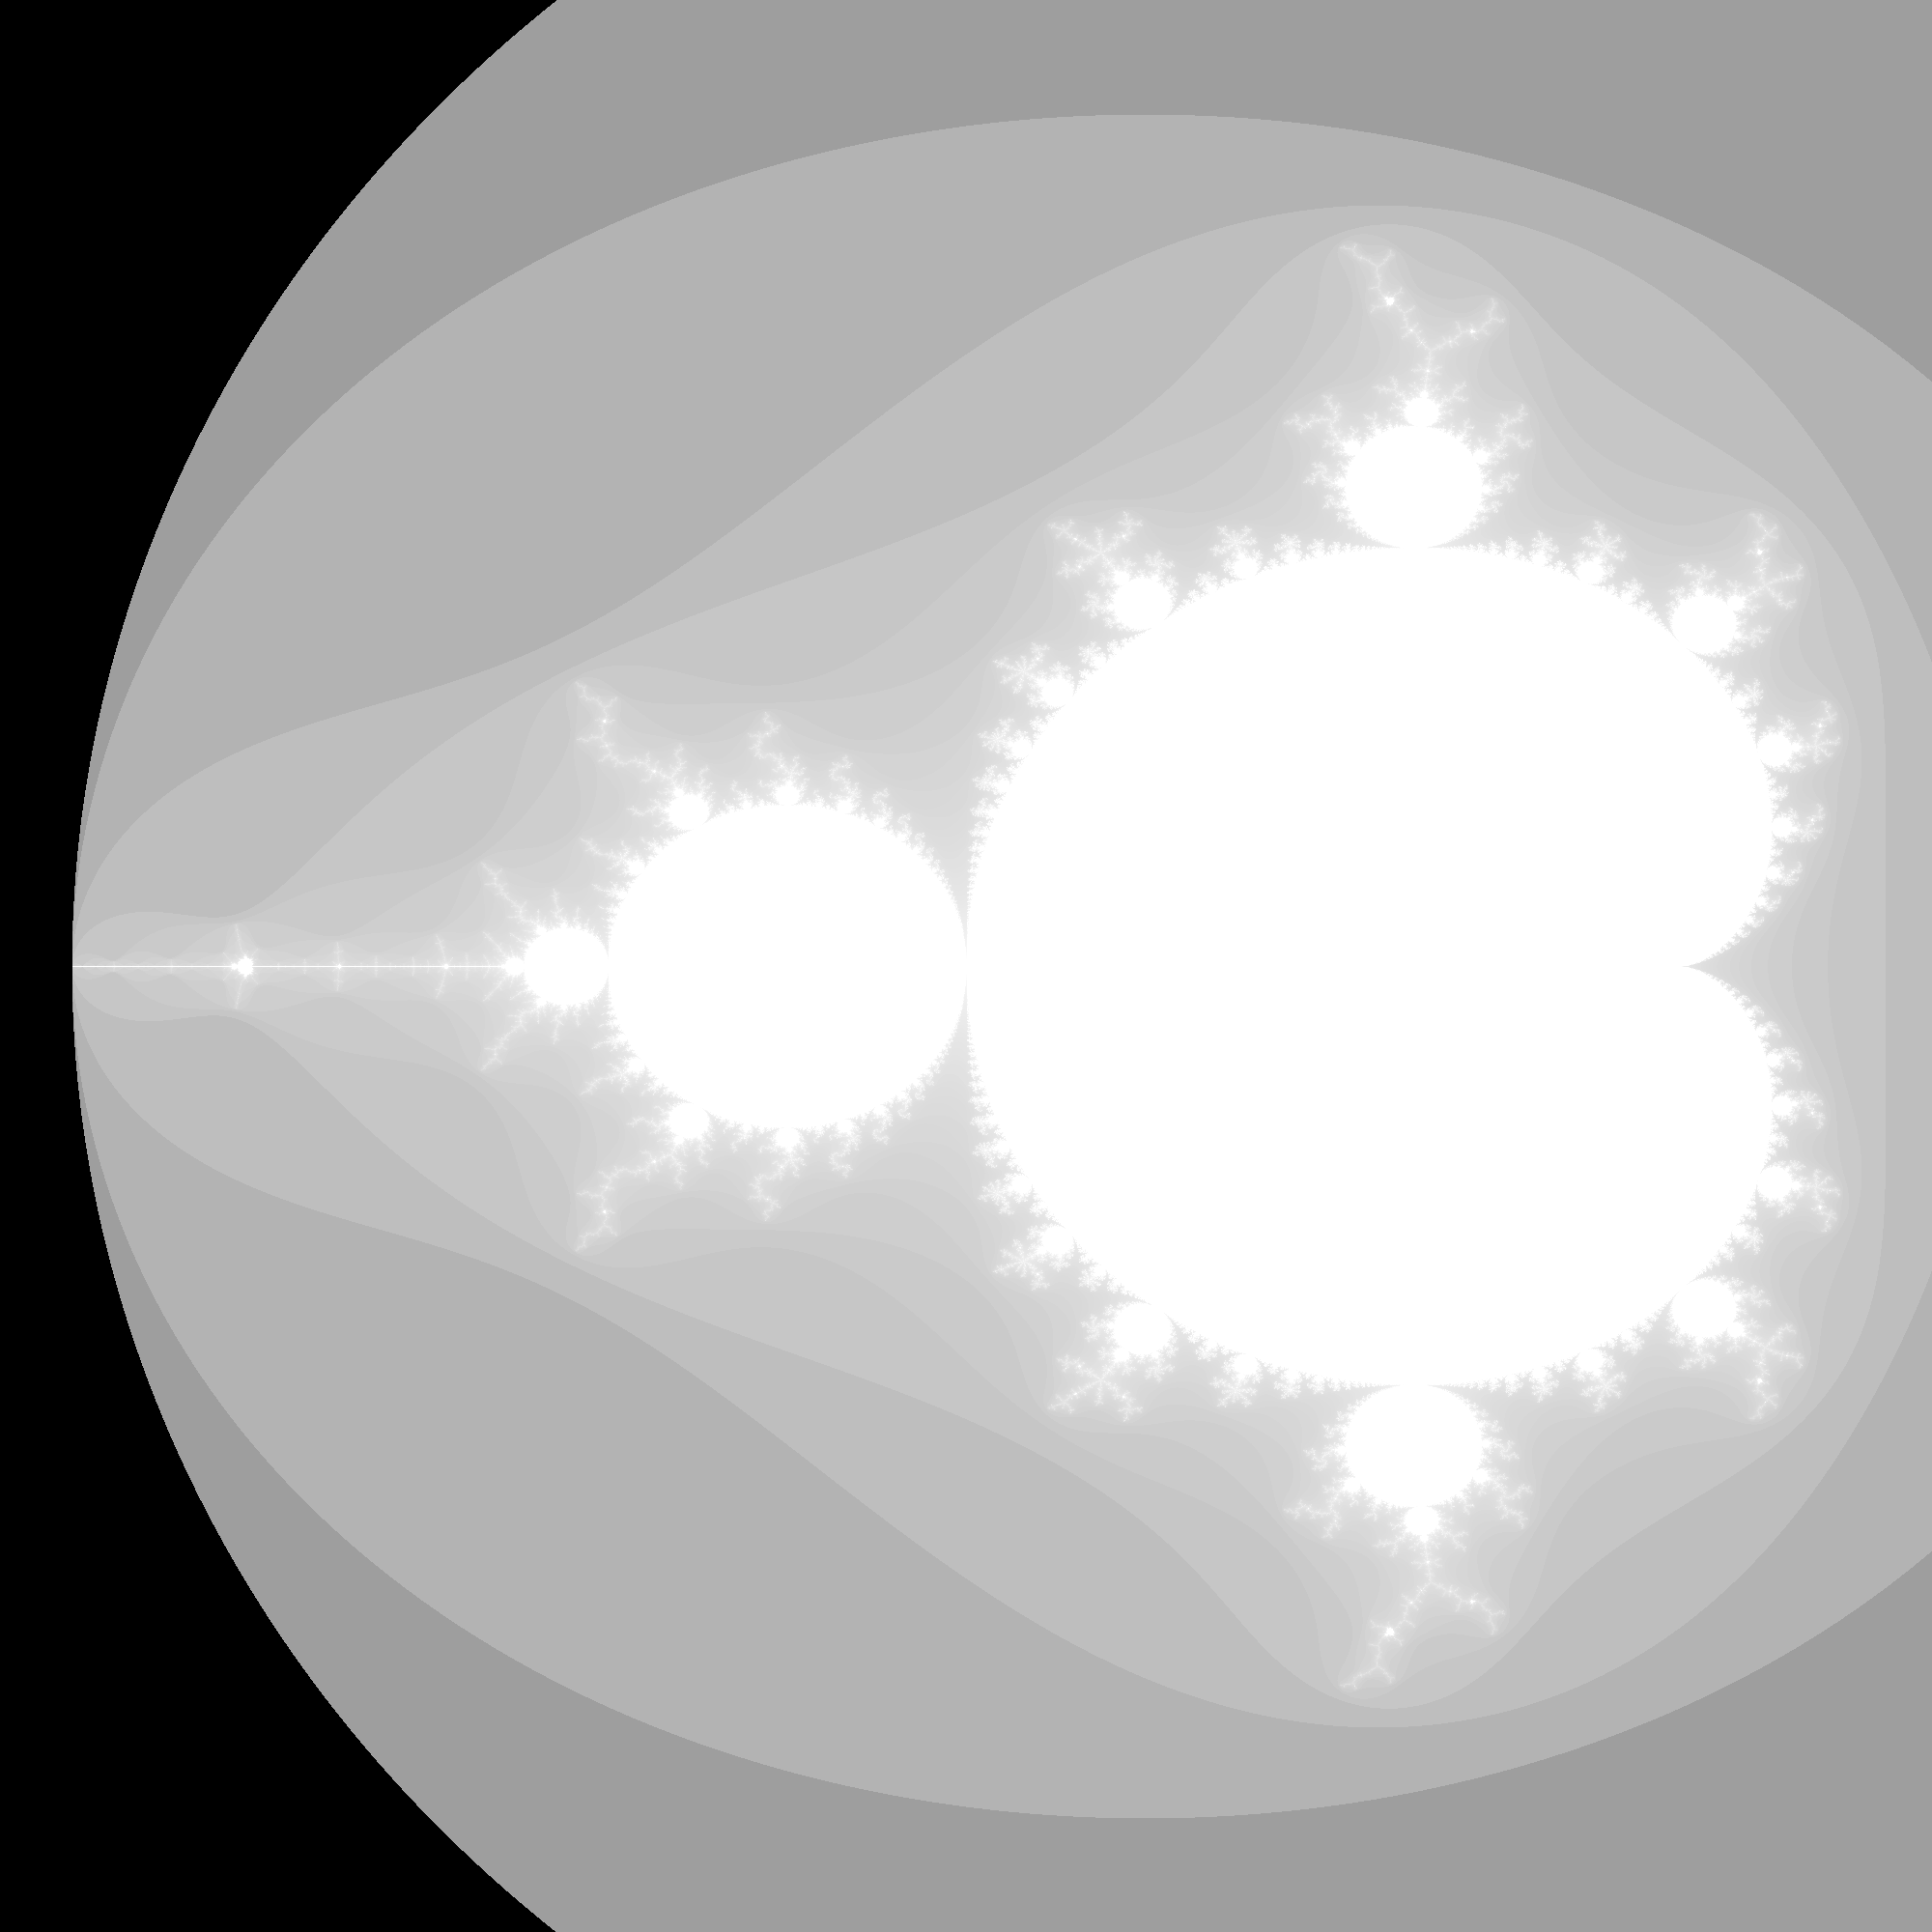

In [10]:
from PIL import Image

# convert values to 0 - 255 int8 format
img=np.log(img)
img = (img/img.max()*255).astype('uint8')
image = Image.fromarray(img)

display(image)

Next we define the interface for

void mandel(double *img, double re1, double re2, double im1, double im2,
	    int nr, int ni, int NTRIALS=255);

First we define the additional variable types we need (note we don't need to define c_double again!)

In [11]:
from ctypes import c_int
from ctypes import POINTER

In [12]:
myclib.mandel.argtypes = [POINTER(c_double), c_double, c_double, c_double, c_double, c_int, c_int, c_int]
myclib.mandel.restype=None

In [14]:
img=np.ndarray(shape=(npX,npY), dtype=np.double) # array to hold our image
%time myclib.mandel(img.ctypes.data_as(POINTER(c_double)),re1,re2,im1,im2,npX,npY,nTrials)

CPU times: user 1.06 s, sys: 3.96 ms, total: 1.06 s
Wall time: 1.11 s


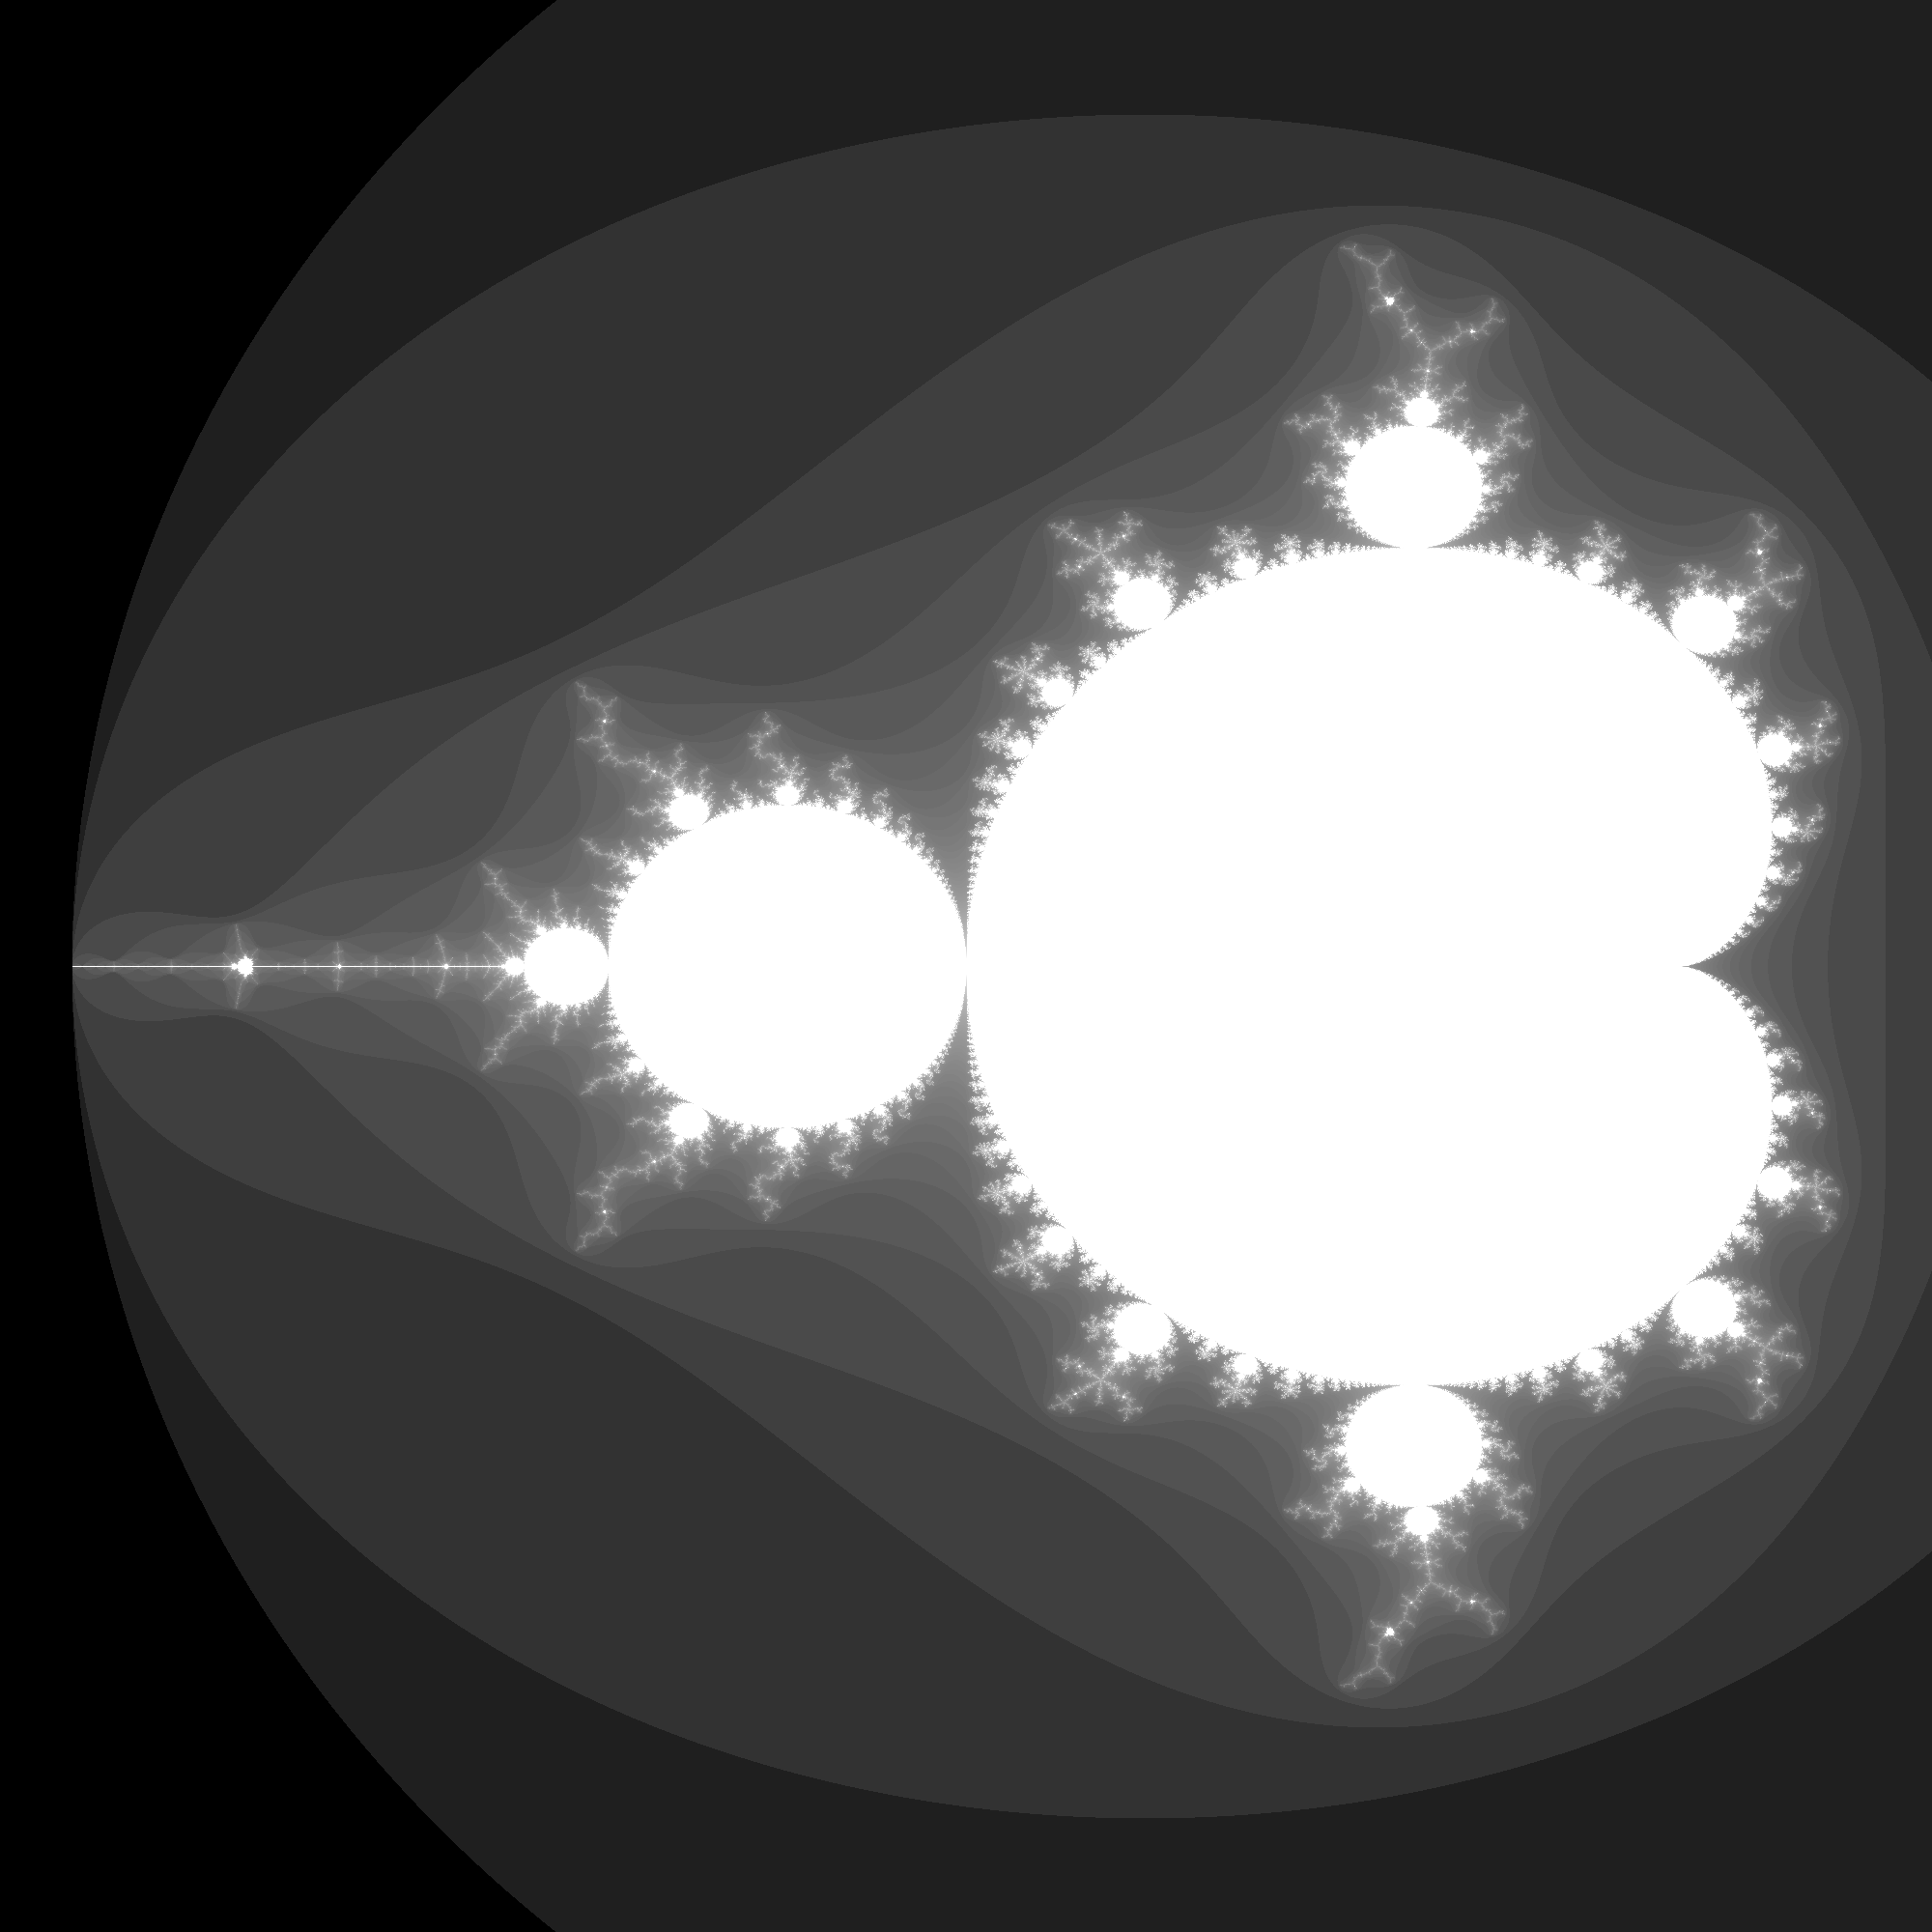

In [11]:
from PIL import Image

# convert values to 0 - 255 int8 format
img=np.log(img)
img = (img/img.max()*255).astype('uint8')
image = Image.fromarray(img)

display(image)

#image = Image.fromarray(img)
#img

Compare to the C example in C-to-Python.ipynb.  In this case you may see that numba is even faster, due to some optimizations that trigger parallelism in the CPU! This [site](https://tbetcke.github.io/hpc_lecture_notes/working_with_numba.html) includes a very detailed analysis of the optimizations performed by numba.

Homework project
=================


Project 2a
----------
Using numpy, see how fast you can perform the estimation of pi using 100M random numbers.  Compare your result to those above. Summarize your result and describe your speed up strategy in your README.md file.  Push your updates to Github.

In [3]:
import numpy

In [3]:
%%timeit -r1 -n1
a=None  # your code here

294 ns ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [4]:
# numpy_pi.py
import numpy as np
from typing import Optional

def estimate_pi_numpy(N: int,
                      seed: Optional[int] = 0,
                      chunk_size: Optional[int] = None,
                      use_float32: bool = True) -> float:
    """
    Estimate pi via Monte Carlo using NumPy vectorization.

    Strategy:
      - If chunk_size is None, default to chunked streaming to keep memory modest.
      - Vectorized inside-count: x*x + y*y <= 1
      - Optional float32 to cut memory/bandwidth in half (often faster).

    Args:
        N: total number of random points
        seed: RNG seed (None for nondeterministic)
        chunk_size: number of points per chunk; if None, auto-choose
        use_float32: generate float32 instead of float64 (fewer bytes, faster I/O)

    Returns:
        Approximation of pi.
    """
    rng = np.random.default_rng(seed)
    dtype = np.float32 if use_float32 else np.float64

    # Heuristic chunk size (~10M) to keep memory reasonable:
    if chunk_size is None:
        # Each chunk allocates ~ 2 * chunk_size * itemsize bytes (+ mask),
        # so 10,000,000 with float32 ≈ 80 MB total temporaries.
        chunk_size = 10_000_000 if use_float32 else 5_000_000

    inside = 0
    remaining = N

    # Use dtype-aware generation when available; fallback to astype
    def rand(n):
        try:
            return rng.random(n, dtype=dtype)
        except TypeError:
            return rng.random(n).astype(dtype, copy=False)

    while remaining > 0:
        m = min(remaining, chunk_size)
        x = rand(m)
        y = rand(m)
        inside += np.count_nonzero(x * x + y * y <= 1.0)
        remaining -= m

    return 4.0 * (inside / N)


In [6]:
import numpy as np
import timeit

# -----------------------------
# Define function right here
# -----------------------------
def estimate_pi_numpy(N=100_000_000, use_float32=True, seed=0):
    rng = np.random.default_rng(seed)
    dtype = np.float32 if use_float32 else np.float64

    # Generate in chunks to avoid running out of memory
    chunk = 10_000_000 if use_float32 else 5_000_000
    inside = 0
    remaining = N

    while remaining > 0:
        n = min(remaining, chunk)
        x = rng.random(n, dtype=dtype)
        y = rng.random(n, dtype=dtype)
        inside += np.count_nonzero(x * x + y * y <= 1.0)
        remaining -= n

    return 4.0 * inside / N

# -----------------------------
# Time the NumPy vectorized version with timeit
# -----------------------------
N = 100_000_000
exec_time = timeit.timeit(lambda: estimate_pi_numpy(N), number=1)
pi_est = estimate_pi_numpy(N)

print(f"N = {N:,}")
print(f"π ≈ {pi_est}")
print(f"Execution time = {exec_time:.3f} seconds")


N = 100,000,000
π ≈ 3.14175612
Execution time = 2.716 seconds


Project 2b (5630 only)
---------------------

In the sample C++ library, add a function HSVolume(d, N, r) that return the volume of a d-dimensional hypersphere with radius, r, using N pseudo random points.  Using the ctypes interface to call this function in Python and make the plot of the error on your calculation of the volume vs N, for N on the range of $1 ... 10^9$
